### Spectral analysis on simulated data

We can simulate EEG-like data using the GDa package using the methods in **GDa.signal.simulate_data**, this data can be used to test different methods. In the current notebook we use simulated data to test the spectral analysis methods.

In [1]:
import sys
sys.path.insert(1, '/home/vinicius/GrayData-Analysis')

import time
import scipy
import h5py
import numpy                 as     np
import xarray                as     xr
import pandas                as     pd
import matplotlib.pyplot     as     plt
from   tqdm                      import tqdm
from   GDa.spectral_analysis     import time_frequency as tf
from   GDa.signal.simulate_data  import white_noise, pink_noise, \
                                        ongoing_non_stationary, \
                                        transient_oscillation_gauss, transient_oscillation_gauss_non_stationary

#### Routine to visualize the data

In [2]:
def plot_data(data_array, chan, fs, n):
    assert type(data_array)==xr.core.dataarray.DataArray, 'Data should be an xarray'
    plt.subplot2grid( (3,3), (0,0), colspan=3 )
    for i in range(data_array.shape[0]):
        plt.plot(data_array.time.values, data_array[i,chan,:], color='b', lw=.2)
    plt.plot(data_array.time.values, data_array[:,chan,:].mean(dim='trials'), color = 'r', lw=3)
    plt.xlim([data_array.time.values.min(), data_array.time.values.max()])
    plt.ylabel('Amplitude', fontsize=12)
    plt.xlabel('Time (s)', fontsize=12)
    plt.subplot2grid( (3,3), (1,0) )
    plt.hist(data_array[:,:,:].values.flatten(), 50)
    plt.ylabel('#', fontsize=12)
    plt.xlabel('Amplitude', fontsize=12)    
    plt.subplot2grid( (3,3), (1,1), colspan=2 )
    data_fft = np.fft.fft( data_array[:,chan,:].values, axis = -1)
    s = np.abs(data_fft) / n
    s[1:] = 2*s[1:]
    f = np.linspace(0,fs/2,n//2)
    plt.plot(f, s.real.mean(axis=0)[:n//2])
    plt.xlim([0,f.max()])
    plt.ylabel('Periodogram', fontsize=12)
    plt.xlabel('Freq (Hz)', fontsize=12)
    plt.subplot2grid( (3,3), (2,0), colspan=3 )
    W = tf.wavelet_transform(data = data_array.values, fs = fs, freqs = np.linspace(5,f.max(),100), n_cycles = 6.0, 
                      time_bandwidth = None, delta = 1, method = 'multitaper', 
                      baseline_correction = False, n_jobs = -1)
    S = np.squeeze( W * np.conj(W) ).real
    plt.imshow(S.mean(axis=0), aspect='auto', cmap='jet', origin='lower', 
           extent=[data_array.time.min(),data_array.time.max(),f[0],f[-1]])
    plt.ylabel('Freq (Hz)', fontsize=12)
    plt.xlabel('Time (s)', fontsize=12)
    plt.tight_layout()

### 1. White noise

White noise can be drawn either from uniform or normal distributions

#### Uniform

In [3]:
signal = white_noise(trials=10, nvars=1, n=1000, fs=250, amp=1, ntype='uniform')

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.1s finished


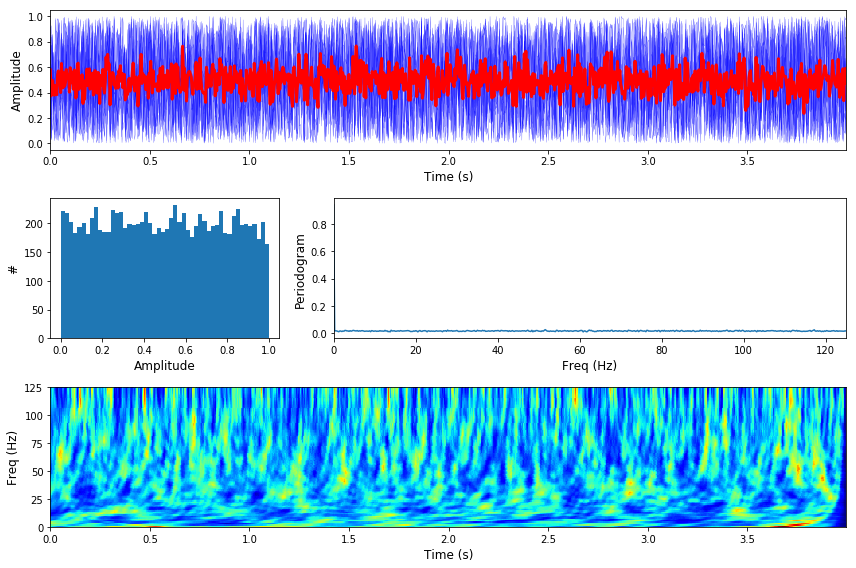

In [4]:
plt.figure(figsize=(12,8))
plot_data(signal, 0,250,1000)

#### Normal

In [5]:
signal = white_noise(trials=10, nvars=1, n=1000, fs=250, amp=1, ntype='normal')

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.6s finished


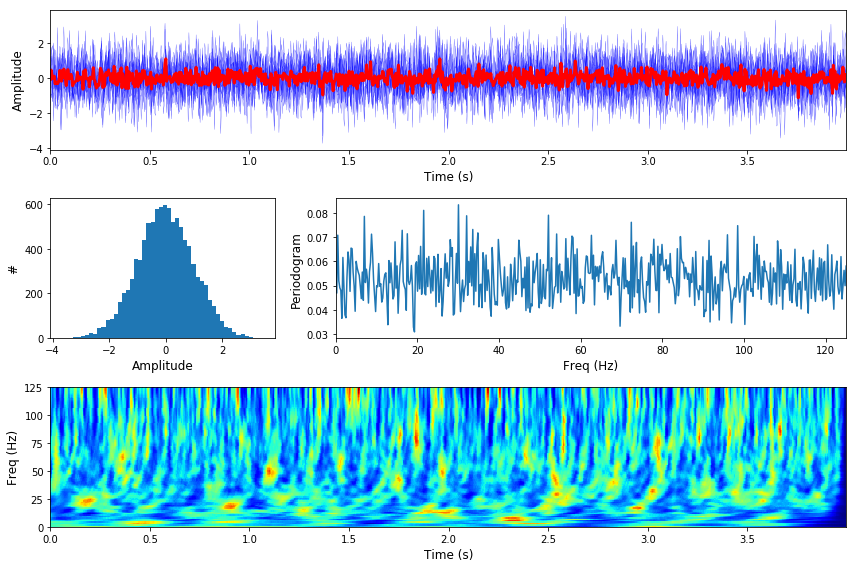

In [6]:
plt.figure(figsize=(12,8))
plot_data(signal, 0,250,1000)

### 2. Pink noise

In [7]:
signal = pink_noise(trials=10, nvars=1, n=1000, fs=250, tau=50)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.6s finished


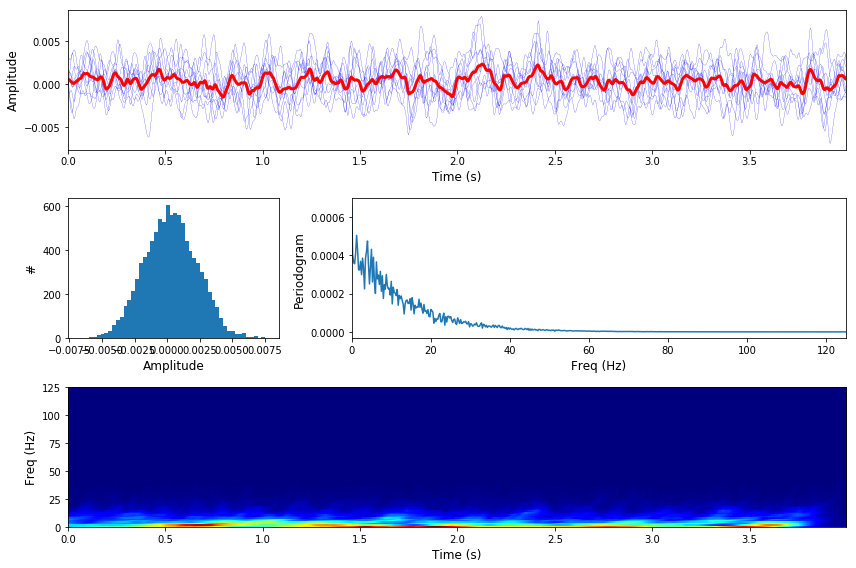

In [8]:
plt.figure(figsize=(12,8))
plot_data(signal, 0,250,1000)

### 3. Ongoing non-stationary signal

In [9]:
signal = ongoing_non_stationary(trials=10, nvars=1, n=1000, fs=250, 
                                peakfreq=np.array([10, 60]), 
                                fwhm=np.array([10, 10]))

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.6s finished


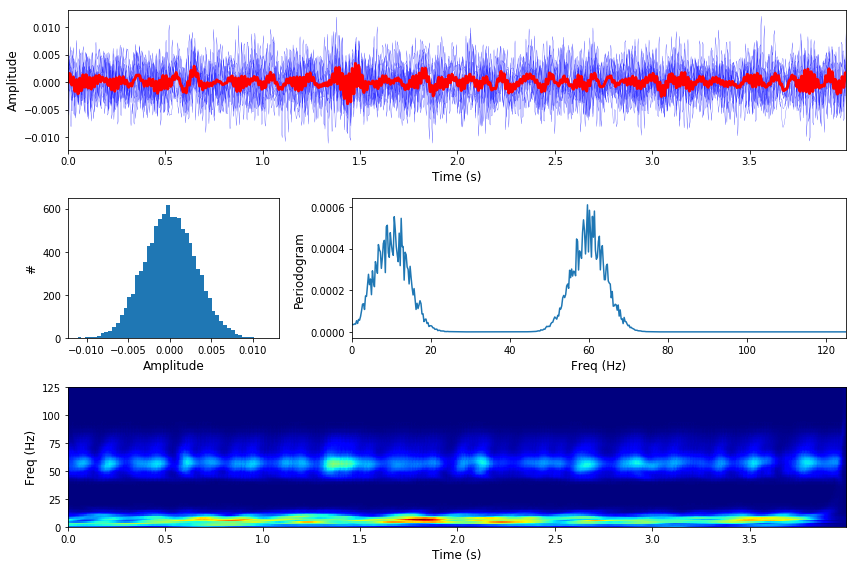

In [10]:
plt.figure(figsize=(12,8))
plot_data(signal, 0,250,1000)

### 4. Transient oscillation with Gaussian

In [11]:
signal = transient_oscillation_gauss(trials=10, nvars=1, n=1000, fs=250, sin_freq=50, 
                                      peaktime=np.array([1,3]), width=np.array([.2,.2]), 
                                      phaselocked=False)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.6s finished


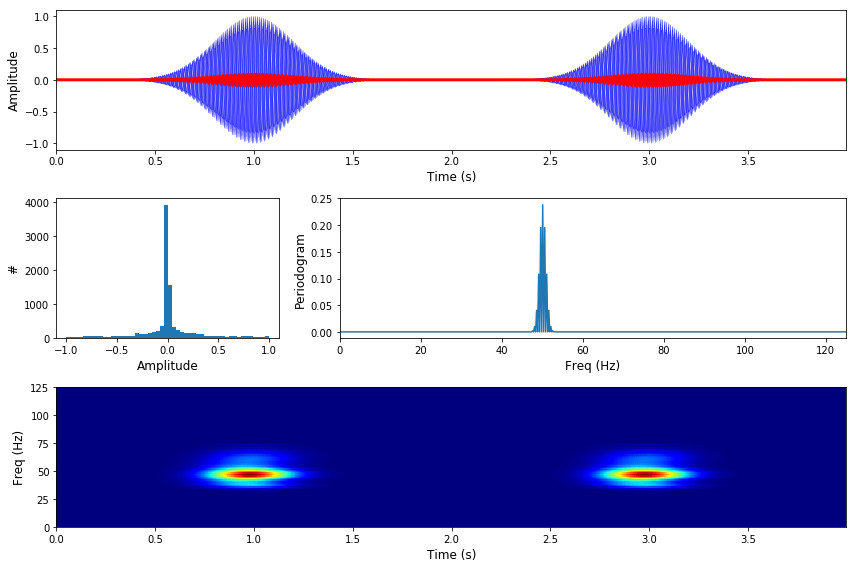

In [12]:
plt.figure(figsize=(12,8))
plot_data(signal, 0,250,1000)

### 5. Transcient non-stationary  signal

In [13]:
signal = transient_oscillation_gauss_non_stationary(trials=10, nvars=1, n=200, fs=60, 
                                                    peakfreq=np.array([21]), fwhm=np.array([5]), 
                                                    peaktime=np.array([1]), width=np.array([0.2]))

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.5s finished


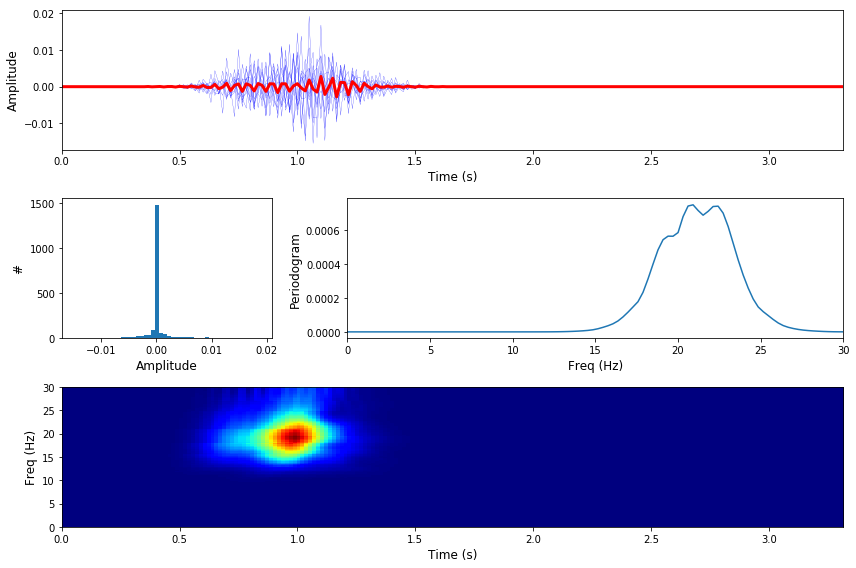

In [14]:
plt.figure(figsize=(12,8))
plot_data(signal,0,60,200)

### Measuring coherence using multitaper technique

To compute the coherence first the cross ($S_{12}(f,t)$), and auto-spectogram ($S_{11}(f,t)$ and $S_{22}(f,t)$) are computed. The coherence is defined as:

$C_{12}(f,t) = \frac{S_{12}S_{12}^{*}}{S_{11}S_{22}}$

However, for the equation above $C_{12}(f,t)=1$ $\forall \text{  } f, \text{ and } t$. Therefore, before taking the ratio in the equation above some temporal and frequency smoothing should be done. To do this, we convolve the auto- and cross-spectogram with a square window of size $w_f$, and $w_rt$, for the frequency and time axis, respectively.

Let's $g(w_t,w_f)$ be the filter, and $\tilde{g}(w_t,w_f)$ its representation in the frequency domain. We can then convolve each spectra with $g$, which gives:

$C_{12}(f,t) = \frac{\tilde{g}*(S_{12}S_{12}^{*})}{\tilde{g}*(S_{11})\tilde{g}*(S_{22})}$

Note that we ommit the dependencies on $f$ and $t$ for the spectra, and on $w_t$ and $w_f$ for the filter.

To estimate the coherence (or spectra) in given bands we can use the multitaper method. Supose that we have the center frequencies of each band $f_c = \{f_{0},\dots, f_{n}\}$, where $n$ is the number of bands, and the bandwidth of each band $\delta f = \{\delta f_{0},\dots,\delta f_{n}\}$.

If $t_b$ is the time bandwidth of the Multitaper transform, the number of cycles can be computed by:

$n_\rm{cycles} = t_b\frac{f_c}{\delta f}$



This can be used to compute the spctra (and the coherence) directly in each band of interest.

First, let's create two signal with localized burts. The first signal with a burst at $1$ s and $3$ s, and the second with a burst only at $3$ s (both with the same width).

In [18]:
T  = 10         # Time interval
fs = 1024       # Sampling frequency
n  = fs*T       # Number of observations

freqs = np.linspace(0.1, 60, 50) # Frequency axis to use on spectral estimation

def gen_signal(T,fs,noise_level=0, seed=0):
    
    np.random.seed(seed)

    x = transient_oscillation_gauss_non_stationary(trials=100, nvars=1, n=n, fs=fs, 
                                                   peakfreq=np.array([21]), fwhm=np.array([5]), 
                                                   peaktime=np.array([4]), width=np.array([.2]))

    y = transient_oscillation_gauss_non_stationary(trials=100, nvars=1, n=n, fs=fs, 
                                                   peakfreq=np.array([21]), fwhm=np.array([5]), 
                                                   peaktime=np.array([4, 8]), width=np.array([.2, 0.2]))

    x_noise = pink_noise(trials=100, nvars=1, n=n, fs=fs, tau=50)
    y_noise = pink_noise(trials=100, nvars=1, n=n, fs=fs, tau=50) 

    signal = xr.DataArray(np.zeros([100,2,n]), dims=("trials", "roi", "time"),
                          coords = {"time": x.time.values})
    signal[:,0,:] = np.squeeze( 10*x.values + noise_level*x_noise.values )
    signal[:,1,:] = np.squeeze( 10*y.values + noise_level*y_noise.values )
    
    return signal

In [24]:
s1 = gen_signal(T,fs,noise_level=3, seed=10) # Signal with no noise
s2 = gen_signal(T,fs,noise_level=3, seed=10) # Signal with no noise

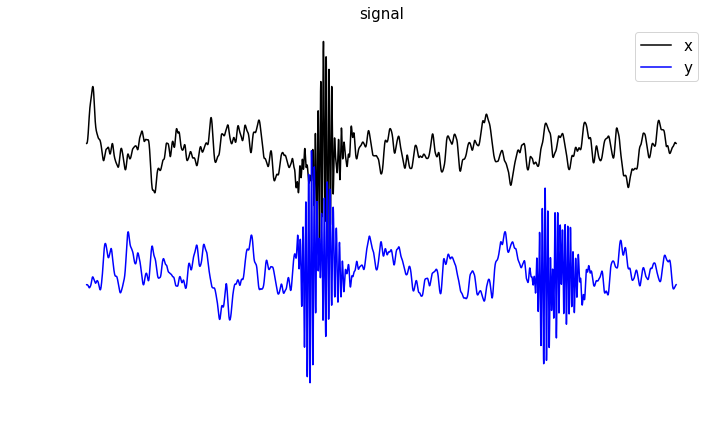

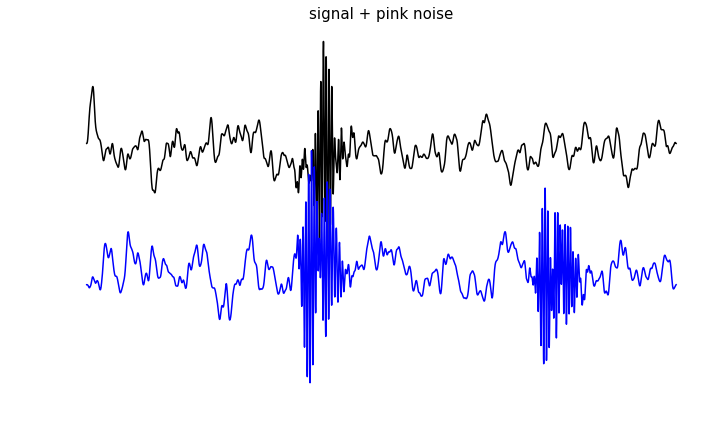

In [25]:
# Plotting ERP of each signal
plt.figure(figsize=(10,6))
plt.plot(s1.time, np.squeeze(s1.mean(dim="trials")).sel(roi=0), 'k')
plt.plot(s1.time, np.squeeze(s1.mean(dim="trials")).sel(roi=1)-.0005, 'b')
plt.legend(['x', 'y'], fontsize=15)
plt.axis('off')
plt.title('signal', fontsize=15)
plt.tight_layout()

plt.figure(figsize=(10,6))
plt.plot(s2.time, np.squeeze(s2.mean(dim="trials")).sel(roi=0), 'k')
plt.plot(s2.time, np.squeeze(s2.mean(dim="trials")).sel(roi=1)-.0005, 'b')
#plt.legend(['x', 'y'], fontsize=15)
plt.axis('off')
plt.title('signal + pink noise', fontsize=15)
plt.tight_layout()

In [27]:
start = time.time()

coh = tf.wavelet_coherence(data = s2.values, pairs = np.array([[0,1]]), fs = fs, 
                     freqs = freqs, n_cycles = freqs/2, time_bandwidth = 10, 
                     delta = 1, method = 'multitaper', kernel='square', win_time = 100, 
                     win_freq = 1, dir_out = 'data',n_jobs = -1)

end = time.time()

print('Elapsed time to load super-tensor: ' +str((end - start)) + ' sec.' )

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:   36.3s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:   36.3s finished


Elapsed time to load super-tensor: 76.52132725715637 sec.


In [28]:
#with h5py.File('data/ch1_0_ch2_1.h5', 'r') as hf:
#    coh = np.array(hf.get('coherence'))

Text(0.5, 0, 'Time [ms]')

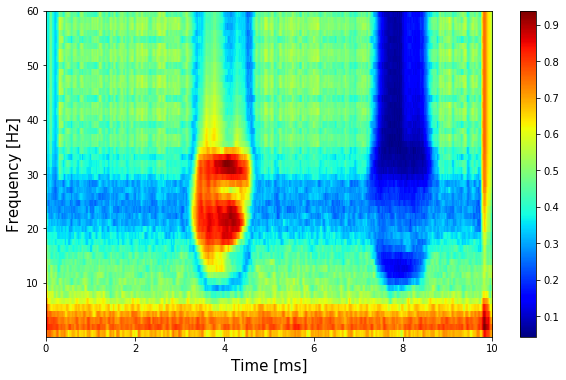

In [29]:
plt.figure(figsize=(10,6))
plt.imshow( np.nanmean(coh, axis=0), aspect='auto', cmap='jet', origin='lower',
           extent=[0,T,freqs[0],freqs[-1]]); plt.colorbar()
plt.ylabel('Frequency [Hz]', fontsize=15)
plt.xlabel('Time [ms]', fontsize=15)

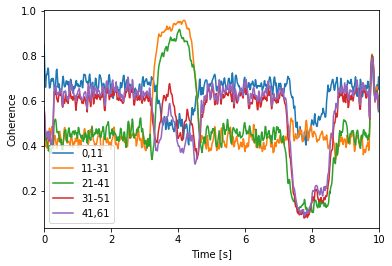

In [30]:
f_l = ['0,11','11-31','21-41','31-51', '41,61']
f_c = np.array([11,21,31,41,51])
d_f = np.ones_like(f_c) * 15
t_b = 8.0
n_cycles = t_b * f_c / d_f

tf.wavelet_coherence(data = s2.values, pairs = np.array([[0,1]]), fs = fs, 
                     freqs = f_c, n_cycles = n_cycles, time_bandwidth = t_b, 
                     delta = 15, method = 'multitaper', win_time = 100, win_freq = 1, 
                     dir_out = 'data',n_jobs = 1)

with h5py.File('data/ch1_0_ch2_1.h5', 'r') as hf:
    coh = np.array(hf.get('coherence'))
    
coh = np.nanmean(coh, axis=0)

for i in range(len(f_c)):
    plt.plot(s2.time.values[::15],coh[i,:], label=f_l[i])
plt.xlim([0,T])
plt.ylabel('Coherence')
plt.xlabel('Time [s]')
plt.legend()

In [31]:
import numpy as np
from matplotlib import pyplot as plt
import mne
from mne import create_info, EpochsArray
from mne.baseline import rescale
from mne.time_frequency import (tfr_multitaper, tfr_stockwell, tfr_morlet,
                                tfr_array_morlet)
#from mne.viz import centers_to_edges

In [32]:
import mne

40 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Need more than one channel to make topography for grad. Disabling interactivity.


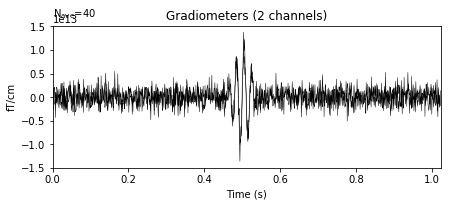

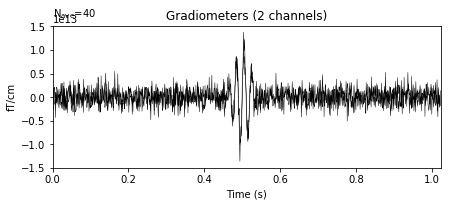

In [33]:
sfreq = 1000.0
ch_names = ['SIM0001', 'SIM0002']
ch_types = ['grad', 'grad']
info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

n_times = 1024  # Just over 1 second epochs
n_epochs = 40
seed = 42
rng = np.random.RandomState(seed)
noise = rng.randn(n_epochs, len(ch_names), n_times)

# Add a 50 Hz sinusoidal burst to the noise and ramp it.
t = np.arange(n_times, dtype=np.float64) / sfreq
signal = np.sin(np.pi * 2. * 50. * t)  # 50 Hz sinusoid signal
signal[np.logical_or(t < 0.45, t > 0.55)] = 0.  # Hard windowing
on_time = np.logical_and(t >= 0.45, t <= 0.55)
signal[on_time] *= np.hanning(on_time.sum())  # Ramping
data = noise + signal

reject = dict(grad=4000)
events = np.empty((n_epochs, 3), dtype=int)
first_event_sample = 100
event_id = dict(sin50hz=1)
for k in range(n_epochs):
    events[k, :] = first_event_sample + k * n_times, 0, event_id['sin50hz']

epochs = EpochsArray(data=data, info=info, events=events, event_id=event_id,
                     reject=reject)

epochs.average().plot()

In [34]:
freqs = np.arange(5., 100., 3.)
vmin, vmax = -3., 3.  # Define our color limits.

In [35]:
np.array(epochs).shape

(40, 2, 1024)

In [36]:
start = time.time()

tf.wavelet_coherence(data = np.array(epochs), pairs = np.array([[0,1]]), fs = sfreq, 
                     freqs = freqs, n_cycles = freqs/2, time_bandwidth = 8, 
                     delta = 15, method = 'multitaper', win_time = 30, win_freq = 1, 
                     dir_out = 'data',n_jobs = 1)

end = time.time()

print('Elapsed time to load super-tensor: ' +str((end - start)) + ' sec.' )

/home/vinicius/.local/lib/python3.6/site-packages/joblib/parallel.py:748: UserWarning: The backend class 'SequentialBackend' does not support timeout. You have set 'timeout=1000000.0' in Parallel but the 'timeout' parameter will not be used.
  self.timeout))


Elapsed time to load super-tensor: 2.988056182861328 sec.


Text(0.5, 0, 'Time [ms]')

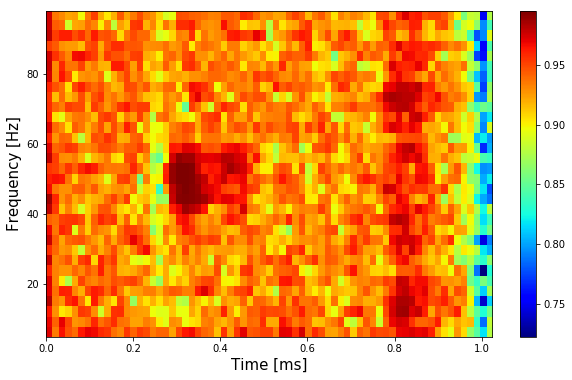

In [37]:
with h5py.File('data/ch1_0_ch2_1.h5', 'r') as hf:
    coh = np.array(hf.get('coherence'))
    
plt.figure(figsize=(10,6))
plt.imshow( np.nanmean(coh, axis=0), aspect='auto', cmap='jet', origin='lower',
           extent=[0,n_times/sfreq,freqs[0],freqs[-1]]); plt.colorbar()
plt.ylabel('Frequency [Hz]', fontsize=15)
plt.xlabel('Time [ms]', fontsize=15)